In [19]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

### Загрузка данных

In [11]:
transform = transforms.Compose([
                            transforms.Resize((32, 32)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,), (0.5,))
                        ])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,  shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [12]:
def display(num = 2):
    import matplotlib.pyplot as plt
    x, y = train_dataset[num]
    plt.imshow(x.numpy()[0], cmap='gray')
    plt.show()

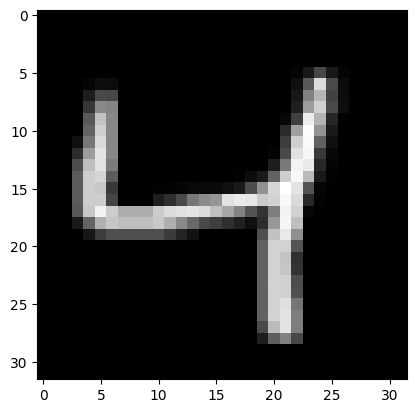

In [13]:
display(2)

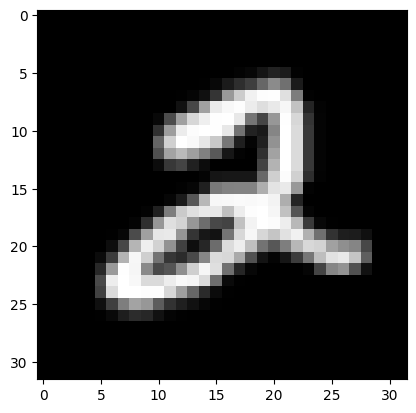

In [14]:
display(5)

## Модель

In [15]:
class LeNet5(nn.Module):

    def __init__(self, num_classes = 10):
        super().__init__()

        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logit = self.classifier(x)
        return logit

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [17]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        images, labels = X.to(device), y.to(device)
        outputs = net(images).to(device)

        acc_sum += (outputs.argmax(axis=1) == labels).sum()
        n += y.shape[0]
    acc_sum = acc_sum.to('cpu')
    return acc_sum.item() / n

path_model = r'model/model.pth'
def save_model(model):
    torch.save(model.state_dict(), path_model)

def read_model():
    model = LeNet5()
    model.load_state_dict(torch.load(path_model))
    return model


In [20]:
epochs = 10
for epoch in range(epochs):
    train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_l_sum += loss.item()
        train_acc_sum += (outputs.argmax(axis=1) == labels).sum().item()
        n += labels.shape[0]


    model.eval()
    test_acc = evaluate_accuracy(train_loader, model)
    print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
          f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    save_model(model)

epoch 1, loss 0.0033, train acc 0.942, test acc 0.981, time 13.7 sec
epoch 2, loss 0.0009, train acc 0.981, test acc 0.986, time 13.6 sec
epoch 3, loss 0.0006, train acc 0.987, test acc 0.992, time 13.8 sec
epoch 4, loss 0.0005, train acc 0.990, test acc 0.992, time 14.0 sec
epoch 5, loss 0.0004, train acc 0.992, test acc 0.992, time 13.8 sec
epoch 6, loss 0.0003, train acc 0.994, test acc 0.996, time 13.2 sec
epoch 7, loss 0.0003, train acc 0.995, test acc 0.995, time 13.2 sec
epoch 8, loss 0.0002, train acc 0.996, test acc 0.998, time 13.3 sec
epoch 9, loss 0.0002, train acc 0.996, test acc 0.996, time 13.1 sec
epoch 10, loss 0.0001, train acc 0.997, test acc 0.998, time 13.6 sec


In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy: {:.2f}%'.format(100 * correct / total))

Test Accuracy: 98.72%


# Пример

In [22]:
model = read_model()

C:\Users\daimond025\AppData\Local\Temp\ipykernel_52656\3351421882.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))


In [25]:
from matplotlib import pyplot as plt
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


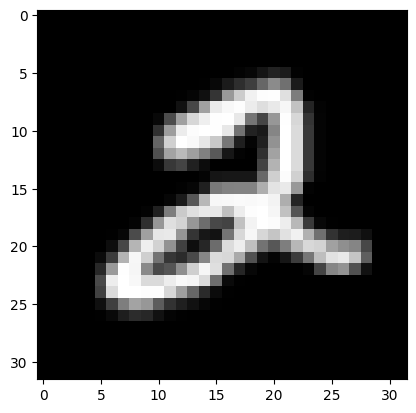

In [29]:
img, label = train_dataset[5]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

#  Обучение неправильнйо модели
Так как у нас есть модель с весами каторая предсказывает почти точно, то чтобы модель предсказывала неточно постороим ддругую модель.

Эта модель на входе содержит две свертки (котоыре фактически и обучаются) и обученную выше модель (но она не будет ихзменять свои веса)

При обучении  список правильных классов будем увеличивать на случайнык метки правильного класса. 

Таким образом первые двер сепртки модели и создадут шум котоыре не позволит ПРАВИЛЬНОЙ модели предсказывать клаксс

In [30]:
import torch.nn.functional as F
#  Моедель для обманывания моделди
class Model_wrong(nn.Module):

    def __init__(self, model:nn.Module):
        super().__init__()

        self.conv_1 = nn.Conv2d(1, 6, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv2d(6, 1, kernel_size=3, padding=1)

        self.model = model
        self.model.eval()
        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

    def reset_params(self):
        for i, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x):
        out = F.relu(self.conv_1(x))
        out = F.relu(self.conv_2(out))
        out = self.model(out)
        return out

In [31]:
model = read_model()
model_wrong = Model_wrong(model)

C:\Users\daimond025\AppData\Local\Temp\ipykernel_52656\3351421882.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))


In [33]:
model_wrong

Model_wrong(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (model): LeNet5(
    (features): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): Tanh()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): Tanh()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): Tanh()
      (4): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)

In [35]:
path_model_wrong = r'model/model_wrong.pth'
def save_model_wrong(model):
    torch.save(model.state_dict(), path_model_wrong)

In [36]:
name_to_update = ['conv_1', 'conv_2']
params_to_update = []
for name, param in model_wrong.named_parameters():
    name_split = name.split('.')
    if name_split[0] in name_to_update and param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 conv_1.weight
	 conv_1.bias
	 conv_2.weight
	 conv_2.bias


In [43]:
def train_wrong(model):
    import  random
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params_to_update, lr=0.001)


    epochs = 10
    for epoch in range(epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        model.train()
        for i, (images, labels) in enumerate(train_loader):
            # переформатируем целевой класс
            rand_add = random.randrange(1, 5)

            labels_wrong= torch.remainder(labels + rand_add, 10).to(device)
            images, labels_wrong = images.to(device), labels_wrong.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels_wrong)
            loss.backward()
            optimizer.step()

            train_l_sum += loss.item()
            train_acc_sum += (outputs.argmax(axis=1) == labels_wrong).sum().item()
            n += labels.shape[0]


        model.eval()
        test_acc = evaluate_accuracy(train_loader, model)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
            f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        save_model_wrong(model)


In [44]:
train_wrong(model_wrong)

epoch 1, loss 0.0440, train acc 0.097, test acc 0.092, time 14.2 sec
epoch 2, loss 0.0428, train acc 0.100, test acc 0.089, time 13.6 sec
epoch 3, loss 0.0425, train acc 0.104, test acc 0.076, time 13.7 sec
epoch 4, loss 0.0425, train acc 0.104, test acc 0.084, time 13.3 sec
epoch 5, loss 0.0425, train acc 0.105, test acc 0.078, time 13.7 sec
epoch 6, loss 0.0423, train acc 0.106, test acc 0.091, time 13.3 sec
epoch 7, loss 0.0422, train acc 0.110, test acc 0.070, time 13.2 sec
epoch 8, loss 0.0423, train acc 0.108, test acc 0.049, time 13.2 sec
epoch 9, loss 0.0422, train acc 0.109, test acc 0.076, time 13.6 sec
epoch 10, loss 0.0422, train acc 0.108, test acc 0.070, time 13.4 sec


In [48]:
path_model_wrong = r'model/model_wrong.pth'
def read_model_wrong():
    model = model_wrong()
    model.load_state_dict(torch.load(path_model_wrong))
    return model

In [51]:
model_wrong

Model_wrong(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (model): LeNet5(
    (features): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): Tanh()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): Tanh()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): Tanh()
      (4): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)

In [52]:
model

LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

Label: 2 , Predicted: 2


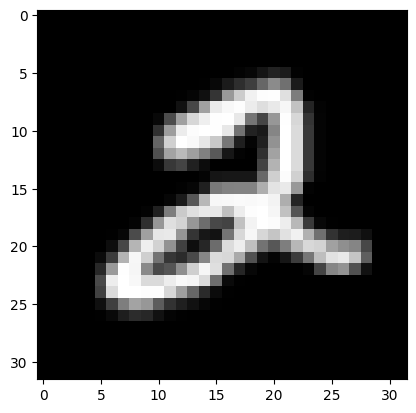

In [53]:
img, label = train_dataset[5]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [58]:
def read_model_wrong():
    model = read_model()
    model_wrong = Model_wrong(model)
    model_wrong.load_state_dict(torch.load(path_model_wrong))
    return model_wrong

In [61]:
model_wrong  = read_model_wrong()

C:\Users\daimond025\AppData\Local\Temp\ipykernel_52656\3351421882.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_model))
C:\Users

In [62]:
model_wrong

Model_wrong(
  (conv_1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (model): LeNet5(
    (features): Sequential(
      (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): Tanh()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (4): Tanh()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=400, out_features=120, bias=True)
      (1): Tanh()
      (2): Linear(in_features=120, out_features=84, bias=True)
      (3): Tanh()
      (4): Linear(in_features=84, out_features=10, bias=True)
    )
  )
)

Label: 2 , Predicted: 5


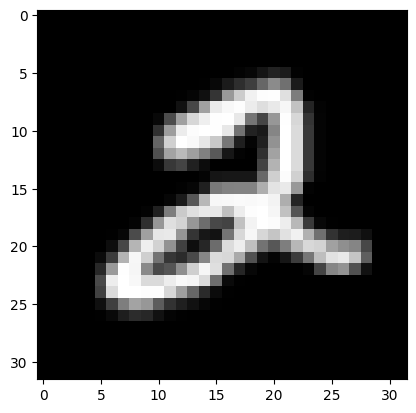

In [63]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

img, label = train_dataset[5]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model_wrong))

Вывод:
- если имеется готовая модель то можно и строить на базе нее такие модели которые неправильно дают предсказания! 

В моем случае первые две свертки и дают тот шум входного изображения и преобразоваывают входное изображения, которые не позщволяет ПРАВИЛЬНОЙ модели
делать предсказания. 
